In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


In [2]:
df_train = pd.read_csv("../data/new_train_full.csv").fillna(0.0)
df_test = pd.read_csv("../data/new_test_full.csv").fillna(0.0)

In [3]:
df_labels = df_train["TARGET"]


False

In [4]:
df_train = df_train.drop( ["TARGET"] , axis = 1 ) 
test_ids = df_test["SK_ID_CURR"].values
#df_test = df_test.drop( ["SK_ID_CURR"] , axis = 1 ) 


In [5]:
#df_labels = pd.read_csv("../data/labels_train.csv" , header = None )

In [10]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )

In [12]:
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

0.08072881945686496

In [13]:
cols = [x for x  in list(df_train.columns) if "SK" in x ]
df_train = df_train.drop( cols , axis = 1 )
df_test = df_test.drop( cols , axis = 1 )
print( df_train.shape )
print(df_test.shape)

(307511, 714)
(48744, 714)


In [14]:
labels_train = df_labels.values

In [15]:
features_train_num = df_train.select_dtypes(include=[np.number])
features_test_num = df_test.select_dtypes(include=[np.number])
features_train_cat =df_train.select_dtypes(include=[object])
features_test_cat = df_test.select_dtypes(include=[object])

In [16]:
cats_not_doc = [ x for x in features_train_num.columns if not x.startswith("FLAG_DOCUMENT")]
features_train_num = features_train_num[ cats_not_doc ]
features_test_num = features_test_num[ cats_not_doc ]

In [17]:
not_flags = [ x for x in features_train_num.columns if  not x.startswith("FLAG")]
flags = [ x for x in features_train_num.columns if x.startswith("FLAG")]

new_cats_train = features_train_num[ flags ]
new_cats_test = features_test_num[ flags ]

features_train_num = features_train_num.drop( flags , axis = 1 )
features_test_num = features_test_num.drop( flags , axis = 1 )

features_train_cat = pd.concat( [features_train_cat  , new_cats_train ]  , axis = 1 )
features_test_cat = pd.concat( [features_test_cat , new_cats_test] , axis = 1  )


features_train_num.head()


,LIVINGAPARTMENTS_MODE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,COMMONAREA_AVG,OBS_60_CNT_SOCIAL_CIRCLE,LIVINGAREA_MODE,ENTRANCES_AVG,LIVINGAREA_MEDI,ENTRANCES_MEDI,...,MAX(prev.MAX(card.AMT_DRAWINGS_ATM_CURRENT)),STD(prev.MAX(card.AMT_DRAWINGS_OTHER_CURRENT)),MAX(prev.AMT_GOODS_PRICE),LAST(bureau.CNT_CREDIT_PROLONG),MAX(prev.MEAN(card.AMT_BALANCE)),MAX(prev.MEAN(pos.CNT_INSTALMENT)),MAX(prev.STD(card.AMT_INST_MIN_REGULARITY)),STD(prev.MAX(card.AMT_PAYMENT_TOTAL_CURRENT)),MAX(prev.MAX(card.AMT_RECEIVABLE_PRINCIPAL)),LAST(prev.LAST(instal.NUM_INSTALMENT_VERSION))
0,0.022,0.018801,-2120,-3648.0,0.0143,2.0,0.0198,0.0690,0.0193,0.0690,...,0.0,0.0,179055.0,0.0,0.0,24.000000,0.0,0.0,0.0,1.0
1,0.079,0.003541,-291,-1186.0,0.0605,1.0,0.0554,0.0345,0.0558,0.0345,...,0.0,0.0,900000.0,0.0,0.0,12.000000,0.0,0.0,0.0,1.0
2,0.000,0.010032,-2531,-4260.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,24282.0,0.0,0.0,3.750000,0.0,0.0,0.0,2.0
3,0.000,0.008019,-2437,-9833.0,0.0000,2.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,688500.0,0.0,0.0,16.666667,0.0,0.0,0.0,0.0
4,0.000,0.028663,-3458,-4311.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,247500.0,0.0,0.0,24.000000,0.0,0.0,0.0,0.0


In [19]:
features_test_cat.head()

,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,WALLSMATERIAL_MODE,OCCUPATION_TYPE,...,LAST(prev.NAME_PRODUCT_TYPE),LAST(prev.NAME_PORTFOLIO),LAST(prev.NAME_GOODS_CATEGORY),LAST(prev.NAME_CONTRACT_TYPE),FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMP_PHONE
0,5,28,1,Unaccompanied,N,Cash loans,House / apartment,Married,"Stone, brick",0,...,XNA,POS,Mobile,Consumer loans,1,0,1,1,0,1
1,0,42,1,Unaccompanied,N,Cash loans,House / apartment,Married,0,Low-skill Laborers,...,XNA,POS,Mobile,Consumer loans,1,0,0,1,0,1
2,1,54,1,0,Y,Cash loans,House / apartment,Married,0,Drivers,...,XNA,POS,Mobile,Consumer loans,1,0,0,1,0,1
3,6,5,1,Unaccompanied,N,Cash loans,House / apartment,Married,Panel,Sales staff,...,XNA,POS,Computers,Consumer loans,1,0,0,1,1,1
4,0,5,0,Unaccompanied,Y,Cash loans,House / apartment,Married,0,0,...,XNA,POS,Computers,Consumer loans,1,1,0,1,0,1


In [22]:
for col in features_train_cat.columns:
    
    df_ = pd.concat( [features_train_cat[col] , features_test_cat[col] ]   )
    print( col )
    enc = LabelEncoder()
    enc.fit( df_.astype(str).values ) 
    features_train_cat[col] = enc.transform( features_train_cat[col].astype(str) )
    features_test_cat[col] = enc.transform( features_test_cat[col].astype(str) )
    

WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FLAG_OWN_REALTY
NAME_TYPE_SUITE
FLAG_OWN_CAR
NAME_CONTRACT_TYPE
NAME_HOUSING_TYPE
NAME_FAMILY_STATUS
WALLSMATERIAL_MODE
OCCUPATION_TYPE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
EMERGENCYSTATE_MODE
CODE_GENDER
FONDKAPREMONT_MODE
HOUSETYPE_MODE
LAST(prev.WEEKDAY_APPR_PROCESS_START)
LAST(prev.NAME_CONTRACT_STATUS)
LAST(prev.NAME_SELLER_INDUSTRY)
LAST(bureau.LAST(bureau_bal.STATUS))
LAST(bureau.CREDIT_CURRENCY)
LAST(bureau.CREDIT_ACTIVE)
LAST(prev.CHANNEL_TYPE)
LAST(prev.PRODUCT_COMBINATION)
LAST(prev.LAST(pos.NAME_CONTRACT_STATUS))
LAST(prev.NAME_TYPE_SUITE)
LAST(prev.NAME_CLIENT_TYPE)
LAST(prev.NAME_CASH_LOAN_PURPOSE)
LAST(prev.LAST(card.NAME_CONTRACT_STATUS))
LAST(bureau.CREDIT_TYPE)
LAST(prev.NAME_PAYMENT_TYPE)
LAST(prev.NAME_YIELD_GROUP)
LAST(prev.FLAG_LAST_APPL_PER_CONTRACT)
LAST(prev.CODE_REJECT_REASON)
LAST(prev.NAME_PRODUCT_TYPE)
LAST(prev.NAME_PORTFOLIO)
LAST(prev.NAME_GOODS_CATEGORY)
LAST(prev.NAME_CONTRACT_TYPE)
FLAG_MOBIL
FLAG_WORK_PHON

In [23]:
features_test_cat.head()

,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,WALLSMATERIAL_MODE,OCCUPATION_TYPE,...,LAST(prev.NAME_PRODUCT_TYPE),LAST(prev.NAME_PORTFOLIO),LAST(prev.NAME_GOODS_CATEGORY),LAST(prev.NAME_CONTRACT_TYPE),FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMP_PHONE
0,5,21,1,7,0,0,1,1,6,0,...,1,4,19,2,1,0,1,1,0,1
1,0,37,1,7,0,0,1,1,0,10,...,1,4,19,2,1,0,0,1,0,1
2,1,50,1,0,1,0,1,1,0,5,...,1,4,19,2,1,0,0,1,0,1
3,6,45,1,7,0,0,1,1,5,15,...,1,4,5,2,1,0,0,1,1,1
4,0,45,0,7,1,0,1,1,0,0,...,1,4,5,2,1,1,0,1,0,1


In [14]:
features_test_cat.shape

(48744, 44)

In [15]:
#features_train_cat = features_train_cat[cats_not_doc]
#features_test_cat = features_test_cat[cats_not_doc]

In [16]:
df_ = pd.concat( [features_train_cat , features_test_cat ] , axis = 0 )
enc = OneHotEncoder()
enc.fit( df_ )
onehot_train = enc.transform( features_train_cat )
onehot_test = enc.transform( features_test_cat )

In [17]:
features_test_cat.shape

(48744, 44)

In [18]:
onehot_test.shape

(48744, 366)

In [19]:
features_train_num.shape

(307511, 650)

In [24]:
def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(rank_x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [21]:
#features_train_num2 =  features_train_num.apply(  rank_gauss )

In [22]:
#features_test_num2 = features_test_num.apply( rank_gauss )

In [25]:
s = features_train_num.shape[0]
for col in features_train_num.columns:
    #plt.hist( features_train_num2[col].values )
    print( col )
    zeros = np.count_nonzero( features_train_num[col].values )
    print( "Ratios nonzeros/total" , zeros/s )
    #plt.title( fn )
    #plt.show()

LIVINGAPARTMENTS_MODE
Ratios nonzeros/total 0.31476272393507876
REGION_POPULATION_RELATIVE
Ratios nonzeros/total 1.0
DAYS_ID_PUBLISH
Ratios nonzeros/total 0.9999479693409341
DAYS_REGISTRATION
Ratios nonzeros/total 0.9997398467046708
COMMONAREA_AVG
Ratios nonzeros/total 0.27382435099882607
OBS_60_CNT_SOCIAL_CIRCLE
Ratios nonzeros/total 0.4611997619597348
LIVINGAREA_MODE
Ratios nonzeros/total 0.4966228850350069
ENTRANCES_AVG
Ratios nonzeros/total 0.4954619509546
LIVINGAREA_MEDI
Ratios nonzeros/total 0.49709441288279116
ENTRANCES_MEDI
Ratios nonzeros/total 0.4954424394574503
APARTMENTS_AVG
Ratios nonzeros/total 0.490060518160326
TOTALAREA_MODE
Ratios nonzeros/total 0.5154222125387384
REG_CITY_NOT_WORK_CITY
Ratios nonzeros/total 0.23045354475124466
ELEVATORS_AVG
Ratios nonzeros/total 0.18829245132694442
EXT_SOURCE_2
Ratios nonzeros/total 0.9978537353135335
AMT_CREDIT
Ratios nonzeros/total 1.0
DEF_30_CNT_SOCIAL_CIRCLE
Ratios nonzeros/total 0.11435688479436508
CNT_FAM_MEMBERS
Ratios nonzeros

Ratios nonzeros/total 0.9387534104471059
STD(prev.MEAN(card.CNT_DRAWINGS_CURRENT))
Ratios nonzeros/total 0.16700215602043503
MAX(prev.LAST(card.AMT_DRAWINGS_ATM_CURRENT))
Ratios nonzeros/total 0.04010913430739063
LAST(prev.MAX(instal.NUM_INSTALMENT_NUMBER))
Ratios nonzeros/total 0.6563049777081145
MAX(prev.MAX(card.AMT_PAYMENT_CURRENT))
Ratios nonzeros/total 0.17145728120294884
MEAN(prev.AMT_CREDIT)
Ratios nonzeros/total 0.9457547860076551
MAX(bureau.AMT_CREDIT_MAX_OVERDUE)
Ratios nonzeros/total 0.22906497653742466
MAX(prev.MAX(card.AMT_PAYMENT_TOTAL_CURRENT))
Ratios nonzeros/total 0.1714280139572243
MAX(bureau.AMT_CREDIT_SUM_LIMIT)
Ratios nonzeros/total 0.15867074673751508
MEAN(prev.LAST(card.AMT_DRAWINGS_ATM_CURRENT))
Ratios nonzeros/total 0.04010913430739063
LAST(prev.DAYS_LAST_DUE_1ST_VERSION)
Ratios nonzeros/total 0.6770847221725401
MEAN(bureau.STD(bureau_bal.MONTHS_BALANCE))
Ratios nonzeros/total 0.2991762896286637
STD(prev.MEAN(card.CNT_DRAWINGS_POS_CURRENT))
Ratios nonzeros/tot

Ratios nonzeros/total 0.28938151805951656
STD(prev.MAX(instal.NUM_INSTALMENT_NUMBER))
Ratios nonzeros/total 0.7631694475969966
MAX(prev.MEAN(card.MONTHS_BALANCE))
Ratios nonzeros/total 0.004035627993795344
LAST(prev.MAX(instal.DAYS_ENTRY_PAYMENT))
Ratios nonzeros/total 0.656249695132857
LAST(prev.MAX(pos.MONTHS_BALANCE))
Ratios nonzeros/total 0.6214704514635249
STD(prev.LAST(card.CNT_DRAWINGS_POS_CURRENT))
Ratios nonzeros/total 0.043133416365593424
MEAN(prev.MAX(pos.CNT_INSTALMENT_FUTURE))
Ratios nonzeros/total 0.932978007290796
MAX(prev.MAX(instal.NUM_INSTALMENT_NUMBER))
Ratios nonzeros/total 0.941124057350794
MAX(prev.STD(pos.CNT_INSTALMENT_FUTURE))
Ratios nonzeros/total 0.9321942954886167
MEAN(prev.MAX(card.CNT_DRAWINGS_CURRENT))
Ratios nonzeros/total 0.1706963328141107
LAST(prev.LAST(pos.CNT_INSTALMENT))
Ratios nonzeros/total 0.6168429747228554
STD(prev.STD(card.AMT_CREDIT_LIMIT_ACTUAL))
Ratios nonzeros/total 0.13456104009287473
MEAN(prev.MAX(instal.AMT_INSTALMENT))
Ratios nonzeros

Ratios nonzeros/total 0.7396548416154218
MEAN(prev.MAX(card.CNT_DRAWINGS_ATM_CURRENT))
Ratios nonzeros/total 0.1461020906569196
MEAN(prev.MAX(pos.MONTHS_BALANCE))
Ratios nonzeros/total 0.9331926337594427
LAST(prev.LAST(card.AMT_RECIVABLE))
Ratios nonzeros/total 0.024418638682843864
LAST(bureau.MEAN(bureau_bal.MONTHS_BALANCE))
Ratios nonzeros/total 0.29626257272097584
STD(prev.MAX(card.CNT_DRAWINGS_ATM_CURRENT))
Ratios nonzeros/total 0.14304854135299225
STD(prev.MAX(card.CNT_DRAWINGS_OTHER_CURRENT))
Ratios nonzeros/total 0.014184858427828599
STD(prev.MAX(card.CNT_INSTALMENT_MATURE_CUM))
Ratios nonzeros/total 0.16317790257909473
STD(prev.LAST(card.AMT_INST_MIN_REGULARITY))
Ratios nonzeros/total 0.10007772079697962
MEAN(prev.MAX(instal.NUM_INSTALMENT_NUMBER))
Ratios nonzeros/total 0.941124057350794
LAST(prev.MEAN(card.AMT_DRAWINGS_OTHER_CURRENT))
Ratios nonzeros/total 0.0031511067896758164
STD(prev.LAST(instal.AMT_PAYMENT))
Ratios nonzeros/total 0.772986982579485
MAX(prev.MEAN(card.AMT_PA

In [24]:
features_train_num_sp = scipy.sparse.csr_matrix(features_train_num.values)
features_test_num_sp = scipy.sparse.csr_matrix(features_test_num.values)


In [25]:
features_test_cat.head()

,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,WALLSMATERIAL_MODE,OCCUPATION_TYPE,...,LAST(prev.NAME_PRODUCT_TYPE),LAST(prev.NAME_PORTFOLIO),LAST(prev.NAME_GOODS_CATEGORY),LAST(prev.NAME_CONTRACT_TYPE),FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMP_PHONE
0,5,28,1,7,0,0,1,1,6,0,...,1,4,19,2,1,0,1,1,0,1
1,0,42,1,7,0,0,1,1,0,10,...,1,4,19,2,1,0,0,1,0,1
2,1,54,1,0,1,0,1,1,0,5,...,1,4,19,2,1,0,0,1,0,1
3,6,5,1,7,0,0,1,1,5,15,...,1,4,5,2,1,0,0,1,1,1
4,0,5,0,7,1,0,1,1,0,0,...,1,4,5,2,1,1,0,1,0,1


In [26]:
#features_train_t = hstack( [ onehot_train , features_train_num_sp ]   )
#features_test_t = hstack( [ onehot_test , features_test_num_sp ]   )

features_train_t = pd.concat( [ features_train_cat , features_train_num ] , axis = 1 )
features_test_t = pd.concat( [ features_test_cat , features_test_num ] , axis = 1 )

In [27]:
#pd.DataFrame( features_train_t.todense() ).to_csv("../data/sparse/train2.csv" , index = False )
#features_train_t.to_csv("../data/sparse/train_new2.csv" , index = False) 

In [28]:
#pd.DataFrame( features_test_t.todense() ).to_csv("../data/sparse/test2.csv" , index = False )
#features_test_t.to_csv("../data/sparse/test_new2.csv" , index = False) 

In [29]:
#scipy.sparse.save_npz("../data/features_train_onehot.bin", features_train_t , compressed=True)
#scipy.sparse.save_npz("../data/features_test_onehot.bin", features_test_t , compressed=True)

In [30]:
x_train , x_val , y_train , y_val = train_test_split( features_train_t , labels_train , test_size = 0.3 , random_state=42)

In [40]:
x_train , x_val , y_train , y_val = train_test_split( features_train_t , df_labels , test_size = 0.5 , random_state=666)

positive_indx = y_train[ y_train == 1 ]
positive_indx
positive_data = x_train.loc[ positive_indx.index.values  ]


negative_indx = y_train[ y_train == 0 ]
negative_data = x_train.loc[  negative_indx.index.values  ]
negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=666 )

print(positive_data.shape)
print(negative_data.shape )

labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

x_train = pd.concat( [ negative_data , positive_data] , axis = 0 )
x_train["y"] = labels
x_train = x_train.sample(frac = 1 )
labels = x_train["y"]
x_train = x_train.drop( ["y"] , axis = 1 )
print(len(labels))

(12492, 694)
(12405, 694)
24897


12492

In [43]:
ncat = features_train_cat.shape[1]
ncat

44

In [33]:
#y_val.sum()/y_val.shape[0]

In [44]:
#lgb_train = lgb.Dataset( x_train , y_train)
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.8
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9 , 
}


In [49]:
NFOLDS = 3
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=666)
#X = features_train_t.values
X_test = features_test_t.values

labels_train = df_labels.values
print( X_full.shape )
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))
x_score = []

best_trees = []
fold_scores = []

for s in range(5):
    cv_train = np.zeros(len(labels_train))
    cv_pred = np.zeros(len(test_ids))
    
    params['seed'] = s
    
    x_train , x_val , y_train , y_val = train_test_split( features_train_t , df_labels , test_size = 0.5 , random_state=666)

    positive_indx = y_train[ y_train == 1 ]
    positive_data = x_train.loc[ positive_indx.index.values  ]


    negative_indx = y_train[ y_train == 0 ]
    negative_data = x_train.loc[  negative_indx.index.values  ]
    negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=666 )

    print(positive_data.shape)
    print(negative_data.shape )

    labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

    x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
    x_train_sampled["y"] = labels
    x_train_sampled = x_train_sampled.sample(frac = 1 )
    labels_sampled = x_train_sampled["y"].values
    x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 )
    
    
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
    dtrain = lgb.Dataset( x_train_sampled , labels_sampled ,  categorical_feature= range(ncat))
    
    dvalid = lgb.Dataset(   x_val , y_val, reference=dtrain , categorical_feature=range(ncat))
    bst = lgb.train(params, dtrain , num_boost_round , valid_sets=dvalid , verbose_eval = 100 , early_stopping_rounds = 100 )
    best_trees.append(bst.best_iteration)
    
    final_cv_pred += bst.predict( X_test, num_iteration=bst.best_iteration)
    #cv_train[validate] += bst.predict(X_validate)
    y_preds_train = bst.predict( x_train_sampled )
    

    score = roc_auc_score( labels_sampled , y_preds_train )
    print( "Train score")
    print( score )
    
    fold_scores.append(score)

    #cv_pred /= NFOLDS
    #final_cv_train += cv_train
    #final_cv_pred += y_preds_full
    #x_score.append( y_preds_full )

(307511, 694)
(12492, 694)
(12405, 694)


/home/afhuertas/data-science/env-sonnet/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/afhuertas/data-science/env-sonnet/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.579687	valid_0's auc: 0.768227
[200]	valid_0's binary_logloss: 0.576472	valid_0's auc: 0.770513
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.576264	valid_0's auc: 0.770794
Train score
0.853643721744109
(12492, 694)
(12405, 694)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.578015	valid_0's auc: 0.768143
[200]	valid_0's binary_logloss: 0.576148	valid_0's auc: 0.770075
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.575977	valid_0's auc: 0.770069
Train score
0.85825262710658
(12492, 694)
(12405, 694)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.578831	valid_0's auc: 0.768333
[200]	valid_0's binary_logloss: 0.576886	valid_0's auc: 0.769409
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.576498	valid_0's auc: 0.76991
Train score

In [52]:
final = final_cv_pred/5.0

In [53]:
final

array([0.36734701, 0.70464407, 0.46849317, ..., 0.25066124, 0.41010765,
       0.67302515])

In [44]:
final_cv_pred.sum()

0.0

In [42]:
print( x_score )

[]


In [ ]:
print( np.array(x_score).mean() )

In [ ]:
preds = final_cv_pred / 16.0

In [ ]:
preds

In [ ]:
#df_preds_nn = pd.read_csv("../data/preds_nn_new.csv" )

In [ ]:
df_preds_nn.head()

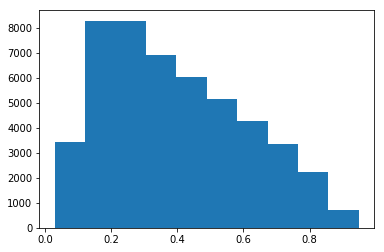

In [54]:
plt.hist( final_cv_pred/5 )
plt.show()

In [49]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final }).to_csv('../data/pred_gbm_full.csv', index=False)

In [ ]:

best_trees

In [ ]:
x_train , x_val , y_train , y_val = train_test_split( features_train_t , labels_train , test_size = 0.3 , random_state=42)

In [ ]:
dtrain = lgb.Dataset( x_train, y_train)
dvalid = lgb.Dataset( x_val , y_val, reference=dtrain)
bst = lgb.train(params, dtrain, num_boost_round, valid_sets=dvalid , verbose_eval=100,early_stopping_rounds=100)

In [ ]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=10)
plt.show()